<Axes: >

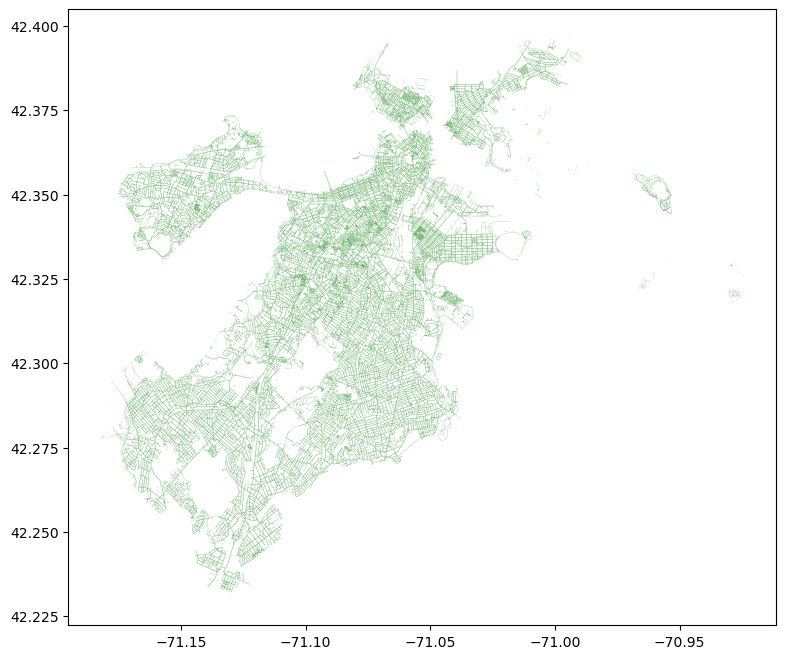

In [92]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point


file_path = 'Sidewalk_Centerline.geojson'
gdf_sidewalk = gpd.read_file(file_path)
fig, ax = plt.subplots(figsize=(10, 8))  # Create a figure and axis

# Plot the GeoDataFrame with thinner lines
gdf_sidewalk.plot(ax=ax, color='green', linewidth=0.1)  # Adjust the linewidth as needed


<Axes: >

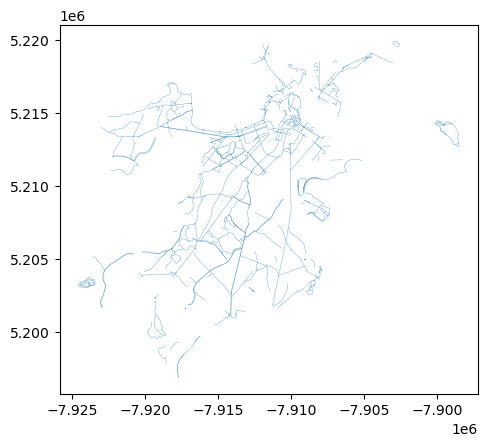

In [93]:
bike_network_shp = 'Existing_Bike_Network_2022.shp'
gdf_bikes = gpd.read_file(bike_network_shp)
gdf_bikes = gdf_bikes.dropna(subset=['geometry'])

gdf_bikes.plot(linewidth=0.2)

<Axes: >

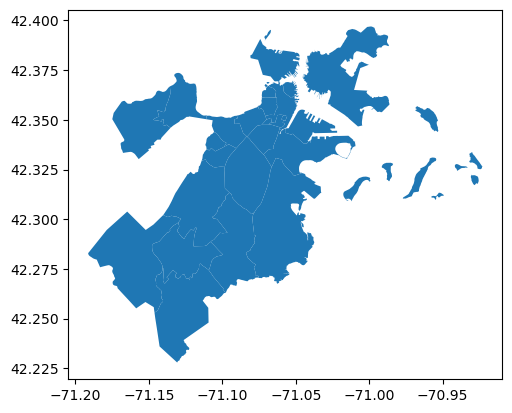

In [94]:
neighborhood_filename = 'boston.geojson'
gdf_neighborhood = gpd.read_file(neighborhood_filename)
gdf_neighborhood.plot()

In [95]:
# Reproject sidewalk and bike path GeoDataFrames to match the CRS of the neighborhood GeoDataFrame
gdf_sidewalk = gdf_sidewalk.to_crs(gdf_neighborhood.crs)
gdf_bikes = gdf_bikes.to_crs(gdf_neighborhood.crs)

In [96]:
# Reproject gdf_sidewalk and gdf_bikes to match the CRS of gdf_neighborhood
gdf_sidewalk = gdf_sidewalk.to_crs(gdf_neighborhood.crs)
gdf_bikes = gdf_bikes.to_crs(gdf_neighborhood.crs)

# Spatial join sidewalk and bike paths with neighborhood
sidewalks_by_neighborhood = gpd.sjoin(gdf_sidewalk, gdf_neighborhood, how="inner", op='intersects')
bike_paths_by_neighborhood = gpd.sjoin(gdf_bikes, gdf_neighborhood, how="inner", op='intersects')

# Group by neighborhood and sum lengths
sidewalk_lengths_by_neighborhood = sidewalks_by_neighborhood.groupby('name')['ShapeSTLength'].sum()
bike_path_lengths_by_neighborhood = bike_paths_by_neighborhood.groupby('name')['Shape_Leng'].sum()

# Create index by summing lengths of sidewalk and bike paths
neighborhood_index = (sidewalk_lengths_by_neighborhood / 10) + bike_path_lengths_by_neighborhood

# Reset the index of the neighborhood index Series
neighborhood_index = neighborhood_index.reset_index(name='Transit_Index')


c:\Users\aadit\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\aadit\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


<Axes: >

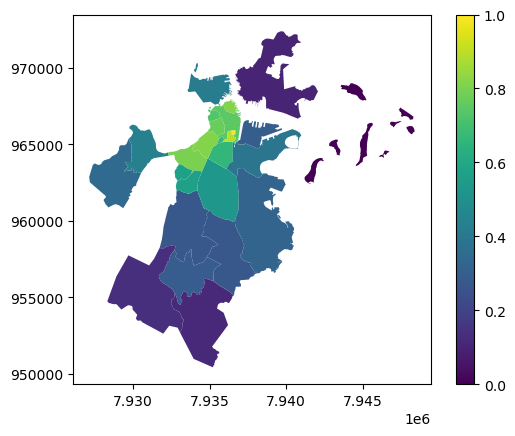

In [97]:

# Define the CRS for the projected coordinate system you want to use
target_crs = 'EPSG:3347'  

# Reproject the neighborhood GeoDataFrame to the target CRS
gdf_neighborhood = gdf_neighborhood.to_crs(target_crs)

# Calculate the area of each neighborhood
gdf_neighborhood['area'] = gdf_neighborhood.geometry.area

# Merge neighborhood transit index with gdf_neighborhood
gdf_neighborhood = gdf_neighborhood.merge(neighborhood_index, on='name', how='left')

# Calculate the transit index per unit area
gdf_neighborhood['Transit_Index_Per_Area'] = gdf_neighborhood['Transit_Index'] / gdf_neighborhood['area']

# Calculate normalized index
min_index = gdf_neighborhood['Transit_Index_Per_Area'].min()
max_index = gdf_neighborhood['Transit_Index_Per_Area'].max()
gdf_neighborhood['Normalized_Index'] = (gdf_neighborhood['Transit_Index_Per_Area'] - min_index) / (max_index - min_index)

# Plot the normalized index
gdf_neighborhood.plot(column='Normalized_Index', cmap='viridis', legend=True)